In [1]:
# import libraries
import time as time
import pandas as pd
import numpy as np
np.random.seed(42)
import sys
import os
import os.path
import itertools
import matplotlib.pyplot as plt

# import custom libraries
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from pkgs.loadData import *
from pkgs.id3Algo import *
from pkgs.svmAlgo import *
from pkgs.results import *
print('packages loaded')

packages loaded


In [2]:
# load data
dataCV, dataTrn, dataTst = loadData('data/csv-format/CVfolds/','data/csv-format/train.csv','data/csv-format/test.csv')

Reading validation fold: 1
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 2
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 3
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold4.csv
   Adding training fold: data/csv-format/CVfolds/fold5.csv
Reading validation fold: 4
   Adding training fold: data/csv-format/CVfolds/fold1.csv
   Adding training fold: data/csv-format/CVfolds/fold2.csv
   Adding training fold: data/csv-format/CVfolds/fold3.csv
   Addi

In [3]:
#%% use training set to build decision trees
trees = {}      
depths = [1,2,4,8]
t_st = time.time()

for maxDepth in depths:
    trees[maxDepth] = {}
    print('\nMax Depth:', maxDepth)
    
    for i in np.arange(200):
        df = dataTrn.sample(int(0.1*len(dataTrn)), replace=True)
        
        # input id3(data, maxDepth, init_depth)
        trees[maxDepth][i] = id3(df.values, maxDepth, 0)
        
        if np.mod(i,10) == 0:
            print('.', end=" ") 
        
t_en = time.time()
t_RunTrees = np.round((t_en - t_st)/60,3)
print('\nRuntime (m):', t_RunTrees)


Max Depth: 1
. . . . . . . . . . . . . . . . . . . . 
Max Depth: 2
. . . . . . . . . . . . . . . . . . . . 
Max Depth: 4
. . . . . . . . . . . . . . . . . . . . 
Max Depth: 8
. . . . . . . . . . . . . . . . . . . . 
Runtime (m): 3.002


In [4]:
#% transform data with decision trees
print('Ensemble Training Data')
dataTrfm_trn = transformData(dataTrn, trees, depths)
print('\nEnsemble Testing Data')
dataTrfm_tst = transformData(dataTst, trees, depths)

print('\nEnsemble Cross-Validation Data\n')
dataTrfm_CV = {}
for f in dataCV:
    print('-> Fold:', f, end=" ")
    dataTrfm_CV[f] = {}
    #print('-Training')
    dataTrfm_CV[f]['trn'] = transformData(dataCV[f]['trn'], trees, depths)
    #print('\n-Validation')
    dataTrfm_CV[f]['val'] = transformData(dataCV[f]['val'], trees, depths)
    
print('\n\ndata transform complete')

Ensemble Training Data

Ensemble Testing Data

Ensemble Cross-Validation Data

-> Fold: 1 -> Fold: 2 -> Fold: 3 -> Fold: 4 -> Fold: 5 

data transform complete


In [5]:
#% run SVM over trees ensemble
def runSVMid3_CV(dataCV, depths, es):
    # Using current time 
    t_st = time.time()
    
    lrs = [10**0, 10**-1, 10**-2, 10**-3, 10**-4, 10**-5]; #intiial learning rates
    Cs = [10**3, 10**2, 10**1, 10**0, 10**-1, 10**-2]; #initial tradeoffs
    #lrs = [0.0001]; Cs = [1000]
    
    hps = list(itertools.product(lrs, Cs))
    best_perf = pd.DataFrame(columns=['Ep','d','lr', 'C', 'acc', 'obj']); 
    T = 10;
        
    for f in dataCV:
        print('-> Fold', f, end=" ")
        
        for d in depths:    
            
            dataVal = dataCV[f]['val'][d] # validation data folds and depths            
            data = pd.DataFrame(dataCV[f]['trn'][d]) # training data folds and depths

            acc0 = 0; # reset accuracy
            
            for lr, C in hps: # for learning rates and tradeoff combinations            
                
                # CV training
                w_best, _, lc, obj, losses = svm(data, lr, C, es, T)
                # CV validation
                X = dataVal[:,1:]; X = np.hstack((X, np.ones((X.shape[0],1)))); # add bias here b/c Val doesn't go to SVM
                y = dataVal[:,0];             
                acc_Val = accuracy(X,y,w_best) # accuracy(X,y,w):               
                
                if acc_Val > acc0: # update best performance
                    best_perf.loc[f] = [len(lc), d, lr, C, acc_Val, obj[-1]]
                    acc0 = acc_Val
            
    print('\n -- Best Performance over CV Folds -- ')
    print(best_perf)        
    print('\nEarly stop:', es)      
    t_en = time.time()
    t_run = np.round((t_en - t_st)/60,3)
    print('\nRuntime (m):', t_run)
    
    return best_perf, t_run

# repeat cross validation
repeats = 3;
reps = {}; runtimes = {}; 
es = 'None'; avgObj = 0; avgAcc  = 0;
for r in range(repeats):
    # input dataCV and early stopping factor
    print('\nTRIAL', r)
    id3SVM_bestHP, t_run = runSVMid3_CV(dataTrfm_CV, depths, es);
    avgObj += id3SVM_bestHP.obj.mean();
    avgAcc += id3SVM_bestHP.acc.mean();
    reps[r] = id3SVM_bestHP;
    runtimes[r] = t_run    

# average cross validation objective value for early stopping definition
avgObj = int(avgObj/repeats)
avgCVacc = avgAcc/repeats

print('\nAverage CV accuracy: {:.4f}'.format(avgCVacc))


TRIAL 0
->Fold - 1 ->Fold - 2 ->Fold - 3 ->Fold - 4 ->Fold - 5 
 -- Best Performance over CV Folds -- 
     Ep    d       lr       C       acc            obj
1  10.0  8.0  0.00100    10.0  0.896861    4349.256971
2  10.0  8.0  0.00001  1000.0  0.899103  355266.695349
3  10.0  8.0  0.00100    10.0  0.908072    4300.645015
4  10.0  8.0  0.00010  1000.0  0.872197  430918.236372
5  10.0  8.0  0.00010   100.0  0.896861   31997.605066

Early stop: None

Runtime (m): 1.674

TRIAL 1
->Fold - 1 ->Fold - 2 ->Fold - 3 ->Fold - 4 ->Fold - 5 
 -- Best Performance over CV Folds -- 
     Ep    d       lr       C       acc            obj
1  10.0  8.0  0.00100    10.0  0.896861    4393.480913
2  10.0  8.0  0.00010   100.0  0.890135   34389.116979
3  10.0  8.0  0.00001   100.0  0.908072   43837.339148
4  10.0  8.0  0.00010   100.0  0.865471   31329.473216
5  10.0  8.0  0.00001  1000.0  0.894619  307307.560172

Early stop: None

Runtime (m): 1.663

TRIAL 2
->Fold - 1 ->Fold - 2 ->Fold - 3 ->Fold - 4 ->F


    Early stop - epoch 3
    Objective values 5741.684 -> 6289.694

Train accuracy: 0.9045


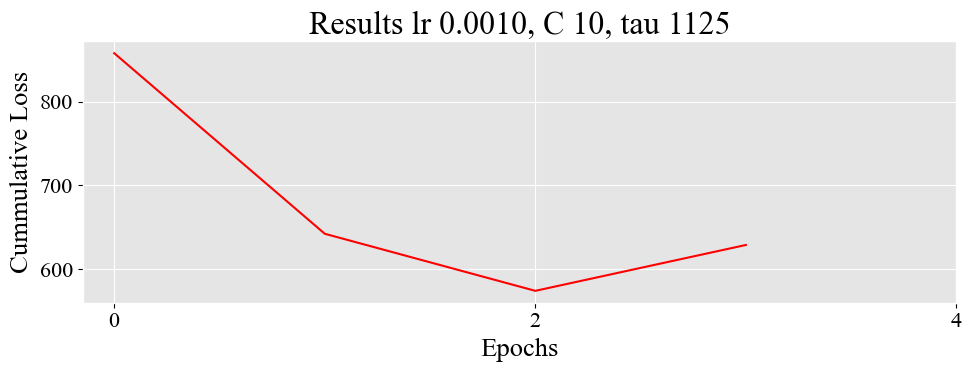

In [17]:
#%% train with best HP

def runSVMid3_trn(dataTrn, lr, C, tau, T):
    
    dataTrn = pd.DataFrame(dataTrn)
    w_best, best_acc, lc, obj, losses = svm(dataTrn, lr, C, tau, T)
    
    print('\nTrain accuracy: {:.4f}'.format(best_acc))
        
    return w_best, best_acc, lc, obj, losses

bestLr = 0.001; bestC = 10; bestDepth = 8;
# early stop condition = 1% of avg. CV objective
bestTau = int(0.01*avgObj); T = 100;

svmID3_Trn = {}
svmID3_Trn['w'], svmID3_Trn['Acc'], svmID3_Trn['LC'], svmID3_Trn['Obj'], svmID3_Trn['Losses'] = runSVMid3_trn(dataTrfm_trn[bestDepth], bestLr, bestC, bestTau, T)

plot_loss(svmID3_Trn['Losses'], bestLr, bestC, bestTau, 'svmID3_trnLoss.pdf')


In [18]:
#%% test with best weight vector

def runSVMid3_test(data, w):
    
    y = data[:,0]
    X = data[:,1:]
    X = np.hstack((X, np.ones((X.shape[0],1)))) # add bias
    
    acc = accuracy(X,y,w);
    
    print('Test accuracy: {:.4f}'.format(acc))
    
    return acc

tstAcc = runSVMid3_test(dataTrfm_tst[bestDepth], svmID3_Trn['w'])

Test accuracy: 0.8351


(1784, 201)